In [1]:
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (5, 3)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [2]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return heatmap

def create_eval_df(model, X_val, y_val, features: list):
    df_eval = X_val.copy()
    df_eval['candidate_pulsar'] = y_val
    df_eval['pred'] = model.predict(X_val)
    df_eval['correct_pred'] = df_eval['pred'] == df_eval['candidate_pulsar']
    df_eval['proba_pulsar'] = model.predict_proba(df_eval[features])[:, 1]
    return df_eval

def plot_roc(true, probas):
    auc = roc_auc_score(true, probas)

    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");
    
def get_store_model_metrics(model_name: str, model_type: str, model, X_val):
    
    preds = model.predict(X_val)
    
    cr = metrics.classification_report(preds, y_val, output_dict = True)
    
    row = pd.DataFrame(data = [[model_name, 
                               model_type,  
                               cr['1']['precision'], 
                               cr['1']['recall'], 
                               cr['1']['f1-score'], 
                               cr['0']['precision'], 
                               cr['0']['recall'], 
                               cr['0']['f1-score'],
                               cr['accuracy']]],
                       columns = results_cols
    )
    
    global model_metrics
    
    model_metrics = model_metrics.append(row)

    return model_metrics

In [3]:
with open('pickles/df_train.pickle','rb') as read_file:
    df = pickle.load(read_file)
    
with open('pickles/df_test.pickle','rb') as read_file:
    df_test = pickle.load(read_file)

In [4]:
# convert target variable to ordered categorical
df.loc[:, 'candidate_pulsar'] = df['candidate_pulsar'].astype('category')
df['candidate_pulsar'] = df['candidate_pulsar'].cat.as_ordered()

In [5]:
df, df_val = train_test_split(df, test_size = 0.2, random_state = 25)

X_val = df_val.iloc[:, :-1]
y_val = df_val.iloc[:, -1]

X_train = df[df.columns[:-1]]
y_train = df.candidate_pulsar

In [8]:
# oversample training data

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

X_ovs, y_ovs = RandomOverSampler(random_state = 25).fit_sample(X_train, y_train)

X_smote, y_smote = SMOTE(random_state = 25).fit_sample(X_train, y_train)

X_adasyn, y_adasyn = ADASYN(random_state = 25).fit_sample(X_train, y_train)

In [9]:
results_cols = ['model_id', 'model_type', '1_precision', '1_recall', '1_f1_score', '0_precision', '0_recall', '0_f1_score', 'accuracy']
model_metrics = pd.DataFrame(columns = results_cols)

# Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler

## Single Feature

### Model: logr_1

---
---

feature = itg_kurtosis  
log reg parameters = default

---

In [11]:
features1 = ['itg_kurtosis']
target = 'candidate_pulsar'

logr1 = LogisticRegression()

logr1.fit(df[features1], df[target])

X_val1 = X_val[features1]

In [12]:
get_store_model_metrics('logr1', 'logistic regression', logr1, X_val1)

model_id           model_type  1_precision  1_recall  1_f1_score  \
0    logr1  logistic regression     0.781818  0.955556        0.86   

   0_precision  0_recall  0_f1_score  accuracy  
0     0.996138  0.977264    0.986611  0.975559

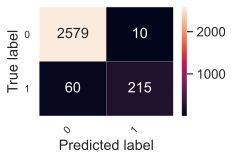

In [14]:
preds_logr1 = logr1.predict(X_val1)

logr1_confusion = confusion_matrix(y_val,
                preds_logr1)

print_confusion_matrix(logr1_confusion, [0,1], figsize = (3,2), fontsize=10);

#### viz

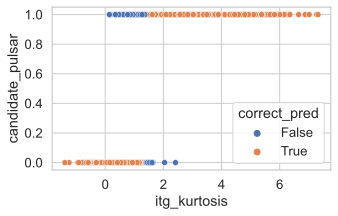

In [125]:
sns.scatterplot(data = df_eval1, 
                x = 'itg_kurtosis',
                y = 'candidate_pulsar',
                hue = 'correct_pred'
               );

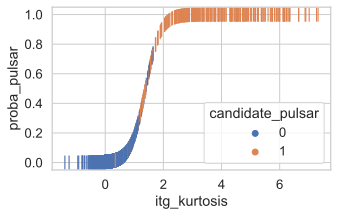

In [126]:
sns.scatterplot(data=df_eval1,
                x='itg_kurtosis',
                y='proba_pulsar',
                hue='candidate_pulsar',
                marker='|',
                s=200);

### Model 2

---
---

feature → itg_kurtosis  
log reg parameters → solver = newton-cg

---


In [15]:
features2 = ['itg_kurtosis']

logr2 = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)
logr2.fit(df[features2], df[target])

X_val2 = X_val[features2]

In [16]:
get_store_model_metrics('logr2', 'logistic regression', logr2, X_val2)

model_id           model_type  1_precision  1_recall  1_f1_score  \
0    logr1  logistic regression     0.781818  0.955556        0.86   
0    logr2  logistic regression     0.781818  0.955556        0.86   

   0_precision  0_recall  0_f1_score  accuracy  
0     0.996138  0.977264    0.986611  0.975559  
0     0.996138  0.977264    0.986611  0.975559

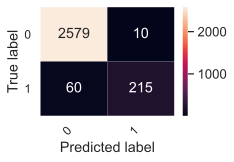

In [19]:
preds_logr2 = logr2.predict(X_val1)

logr2_confusion = confusion_matrix(y_val,
                preds_logr2)

print_confusion_matrix(logr2_confusion, [0, 1], figsize = (3,2), fontsize=12);

## Multiple Logistic Regression

### Model 3

---
---

features = itg_mean, itg_kurtosis

---

In [20]:
features3 = ['itg_mean', 'itg_kurtosis']

scaler3 = StandardScaler()
X_train3 = scaler3.fit_transform(df[features3])

In [22]:
logr3 = LogisticRegression(C = 10000)

logr3.fit(X_train3, y_train)

X_val3 = scaler3.transform(df_val[features3])

In [23]:
get_store_model_metrics('logr3', 'logistic regression', logr3, X_val3)

model_id           model_type  1_precision  1_recall  1_f1_score  \
0    logr1  logistic regression     0.781818  0.955556    0.860000   
0    logr2  logistic regression     0.781818  0.955556    0.860000   
0    logr3  logistic regression     0.789091  0.968750    0.869739   

   0_precision  0_recall  0_f1_score  accuracy  
0     0.996138  0.977264    0.986611  0.975559  
0     0.996138  0.977264    0.986611  0.975559  
0     0.997296  0.978030    0.987569  0.977304

### Model 4

---
---

All features.

---

In [27]:
scaler4 = StandardScaler()
X_train4 = scaler4.fit_transform(X_train)

logr4 = LogisticRegression(C = 10000)
logr4.fit(X_train4, y_train)

X_val4 = scaler4.transform(X_val)

In [28]:
get_store_model_metrics('logr4', 'logistic regression', logr4, X_val4)

model_id           model_type  1_precision  1_recall  1_f1_score  \
0    logr1  logistic regression     0.781818  0.955556    0.860000   
0    logr2  logistic regression     0.781818  0.955556    0.860000   
0    logr3  logistic regression     0.789091  0.968750    0.869739   
0    logr4  logistic regression     0.829091  0.946058    0.883721   

   0_precision  0_recall  0_f1_score  accuracy  
0     0.996138  0.977264    0.986611  0.975559  
0     0.996138  0.977264    0.986611  0.975559  
0     0.997296  0.978030    0.987569  0.977304  
0     0.994979  0.982082    0.988488  0.979050

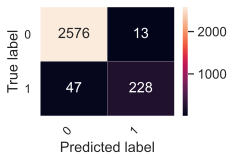

In [31]:
preds4 = logr4.predict(X_val4)

lr4_confusion = confusion_matrix(df_val['candidate_pulsar'],
                preds4)

print_confusion_matrix(lr4_confusion, [0, 1], figsize = (3,2), fontsize=12);

### Model 5

---
---

Add polynomial and interaction features to Model 4

---

In [138]:
from sklearn.preprocessing import PolynomialFeatures

In [172]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)

scaler = StandardScaler()
X_poly_sc = scaler.fit_transform(X_poly)

logr5 = LogisticRegression(C = 10000)
logr5.fit(X_poly_sc, y)
X_poly_sc.shape

/Users/emma-clairemccarthy/opt/anaconda3/envs/ids/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(11454, 45)

In [166]:
X_val = df_val[df_val.columns[:-1]]
y_val = df_val[df_val.columns[-1]]

(2864, 8)

In [170]:
val_poly = scaler.transform(X_val)

val_poly_sc = poly.transform(val_poly)

preds5 = logr5.predict(val_poly_sc)

ValueError: X has 45 features per sample; expecting 8

In [ ]:
confusion_matrix(df_val['candidate_pulsar'],
                preds4)

# Gaussian Naive Bayes

---
---

validation set score = 0.946

---

In [41]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB

In [42]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [44]:
gnb = GaussianNB()
gnb.fit(X, y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [136]:
gnb.score(df_val.iloc[:, :-1], df_val.iloc[:, -1])

0.9455307262569832

In [50]:
gnb.theta_

array([[116.50698828,  47.34269085,   0.21045615,   0.38354185,
          8.86805648,  23.21326426,   8.88734171, 114.30602712],
       [ 56.52088356,  38.68094295,   3.11311102,  15.35101809,
         50.1749846 ,  56.56168604,   2.72557168,  17.24349448]])

In [52]:
np.sqrt(gnb.sigma_)

array([[ 17.54721341,   6.22099451,   0.33798154,   1.03649617,
         24.4807913 ,  16.6344317 ,   4.25733854, 108.4498163 ],
       [ 29.03181905,   7.83878416,   1.8406879 ,  13.86068031,
         45.8692786 ,  19.67380186,   3.03808143,  43.23130301]])

In [62]:
gnb.class_prior_

array([0.90946394, 0.09053606])

In [63]:
gnb.classes_

array([0, 1])

Do the predictions change when using the log probabilities?

In [68]:
log_preds = [list(x).index(max(list(x))) for x in gnb.predict_log_proba(df_val.iloc[:, :-1])]

In [70]:
match = [x == y for x, y in zip(log_preds, gnb.predict(df_val.iloc[:, :-1]))]

In [79]:
count = 0
for i in match:
    if i == False:
        count += 1 
print(count, 'class assignment differences between standard and log_proba.')

0 class assignment differences between standard and log_proba.


# KNN

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [8]:
# merge df and df_val so cross validation can be used instead
cv_df = pd.concat([df, df_val])
cv_df.shape

(14318, 9)

In [20]:
cv_X = df.iloc[:, :-1]
cv_y = df.iloc[:, -1]
val_X = df_val.iloc[:, :-1]
val_y = df_val.iloc[:, -1]

## Model 1

---
---

weights = uniform

---

In [15]:
knn1 = KNeighborsClassifier(n_neighbors = 5)
scores = cross_val_score(knn1, cv_X, cv_y, cv=10, scoring='accuracy')


print(scores)
print(scores.mean())

[0.97033159 0.98167539 0.96684119 0.97294939 0.96943231 0.9650655
 0.97554585 0.96943231 0.98165939 0.97729258]
0.9730225504317275


In [21]:
knn1.fit(cv_X, cv_y)
preds = knn1.predict(val_X)
print(metrics.classification_report(preds, val_y))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2642
           1       0.73      0.92      0.82       222

    accuracy                           0.97      2864
   macro avg       0.86      0.95      0.90      2864
weighted avg       0.97      0.97      0.97      2864



Text(0, 0.5, 'Cross-Validated Accuracy')

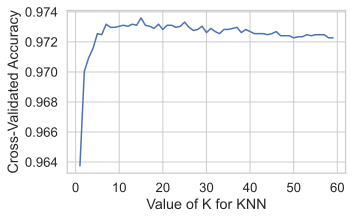

In [11]:
k_range = list(range(1, 60))

k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    mean_score = cross_val_score(knn, cv_X, cv_y, cv=10, scoring='accuracy').mean()
    k_scores.append(mean_score)
    
sns.lineplot(x = k_range, y = k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

## Model 2

---
---

weights = distance

---

In [116]:
k_range_d = list(range(1, 60))

k_scores_d = []

for k in k_range_d:
    knn = KNeighborsClassifier(n_neighbors = k, weights = 'distance')
    mean_score = cross_val_score(knn, cv_X, cv_y, cv=10, scoring='accuracy').mean()
    k_scores_d.append(mean_score)

Text(0, 0.5, 'Cross-Validated Accuracy')

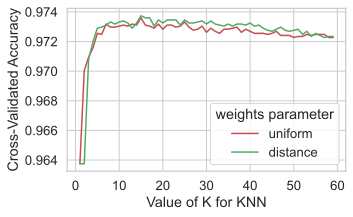

In [117]:
plt.plot(k_range, k_scores, 'r-', k_range_d, k_scores_d, 'g-')
plt.legend(['uniform', 'distance'], title = 'weights parameter')
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [123]:
# overall, knn performs better using 'distance' for the weights parameter

# best k:

best_score = 0
best_k = 0

for k, score in zip(k_range_d, k_scores_d):
    if score > best_score:
        best_score = score
        best_k = k
        
print('best score:', round(best_score, 3))
print('best k:', best_k)

best score: 0.974
best k: 15


In [134]:
# check other parameters for potential accuracy improvements

for dis_code, dis in zip([1, 2], ['manhattan dist', 'euclidian dist']):    
    for a in ['auto', 'ball_tree', 'kd_tree', 'brute']:
        knn = KNeighborsClassifier(n_neighbors = 15, weights = 'distance', algorithm = a, p = dis_code)
        mean_score = cross_val_score(knn, cv_X, cv_y, cv=10, scoring='accuracy').mean()

        print(dis, '|', a, '|', mean_score)
    print('-------')

manhattan dist | auto | 0.974227939597656
manhattan dist | ball_tree | 0.974227939597656
manhattan dist | kd_tree | 0.974227939597656
manhattan dist | brute | 0.974227939597656
-------
euclidian dist | auto | 0.9737389175831256
euclidian dist | ball_tree | 0.9737389175831256
euclidian dist | kd_tree | 0.9737389175831256
euclidian dist | brute | 0.9737389175831256
-------


In [51]:
knn2_confusion = confusion_matrix(val_y,
                preds2)

1: candidate pulsar
0: radio interference

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2645
           1       0.74      0.94      0.83       219

    accuracy                           0.97      2864
   macro avg       0.87      0.96      0.90      2864
weighted avg       0.98      0.97      0.97      2864



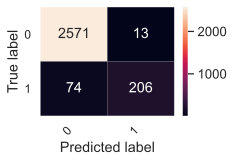

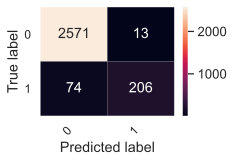

In [60]:
knn2 = KNeighborsClassifier(n_neighbors = 15)

knn2.fit(cv_X, cv_y)
preds2 = knn2.predict(val_X)
print('1: candidate pulsar\n0: radio interference\n')
print(metrics.classification_report(preds2, val_y))
print_confusion_matrix(knn2_confusion, [0, 1], figsize = (3,2), fontsize=12)

array([[2571,   13],
       [  74,  206]])

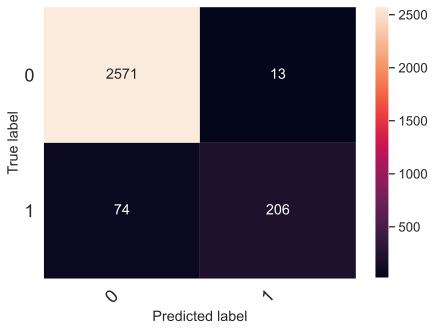

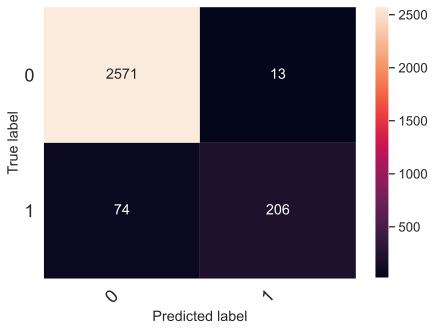

In [50]:
print_confusion_matrix(knn2_confusion, [0, 1], figsize = (7,5), fontsize=18)